In [43]:
import os
import tqdm
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [44]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg').eval().cuda()
for param in dinov2.parameters():
    param.requires_grad = False

Using cache found in /home/bea/.cache/torch/hub/facebookresearch_dinov2_main


## Visualize

In [45]:
transform = transforms.Compose([           
    transforms.Resize(520),
    transforms.CenterCrop(518), #should be multiple of model patch_size                 
    transforms.ToTensor(),                    
    transforms.Normalize(mean=0.5, std=0.2)
])
patch_size = dinov2.patch_size # patchsize=14
patch_h  = 520//patch_size
patch_w  = 520//patch_size
feat_dim = 384 # vits14

In [46]:
folder_path = "/datasets/annotation_final_imagenet/static_real/state/train"
total_features  = []
labels = []
with torch.no_grad():
    for label in tqdm.tqdm(os.listdir(folder_path)):
        for img_path in np.random.choice(os.listdir(os.path.join(folder_path, label)), 24):
            img_path = os.path.join(folder_path, label, img_path)
            img = Image.open(img_path).convert('RGB')
            img_t = transform(img).cuda()

            features_dict = dinov2.forward_features(img_t.unsqueeze(0))
            features = features_dict['x_norm_patchtokens']
            total_features.append(features)
            labels.append(label)

all_total_features = total_features = torch.cat(total_features, dim=0)
all_labels = labels = np.array(labels)
total_features.shape, labels.shape

  3%|▎         | 1/35 [00:00<00:24,  1.40it/s]


KeyboardInterrupt: 

In [ ]:
obj = 'tortilla'
keep = np.array([l[:len(obj)] == obj for l in all_labels])
total_features = all_total_features[keep]
labels = all_labels[keep]
total_features.shape, labels.shape


(torch.Size([312, 1369, 384]), (312,))

(array([ 4493., 39661., 76566., 55817., 43396., 48917., 66645., 66347.,
        23674.,  1612.]),
 array([0.09708603, 0.16927254, 0.24145904, 0.31364554, 0.38583204,
        0.45801854, 0.53020505, 0.60239155, 0.67457805, 0.74676455,
        0.81895105]),
 <BarContainer object of 10 artists>)

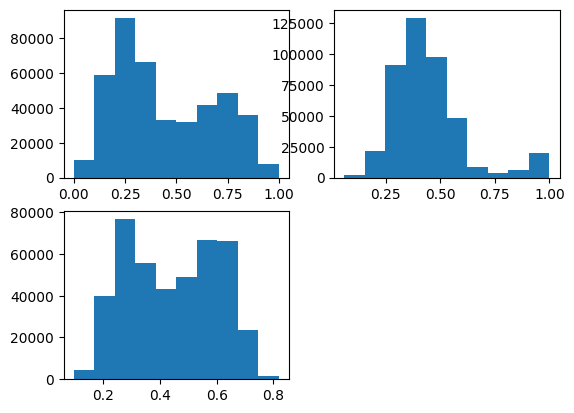

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(-1, feat_dim).cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)
pca_features = (pca_features - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
pca_features = np.clip(pca_features, 0, 1)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])

In [ ]:
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())

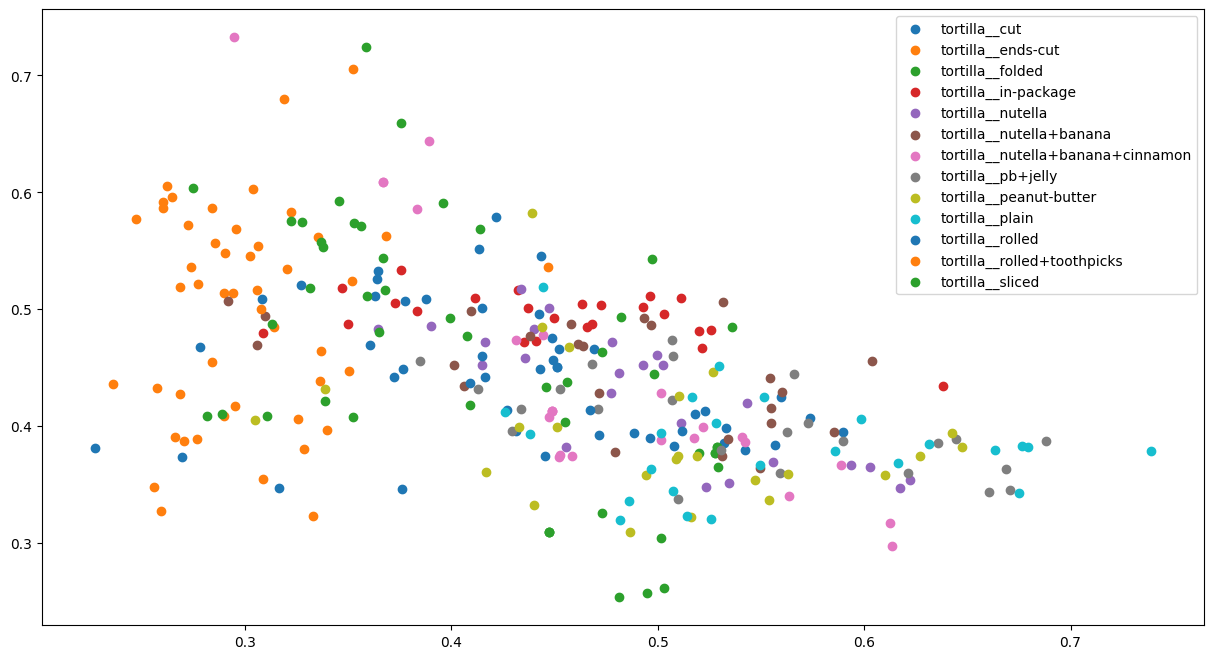

In [ ]:
plt.figure(figsize=(15, 8))
for l in np.unique(labels):
    p = pca_features.reshape(-1, patch_h, patch_w, 3).mean(1).mean(1)
    plt.scatter(p[labels==l, 0], p[labels==l, 1], label=l)
plt.legend()

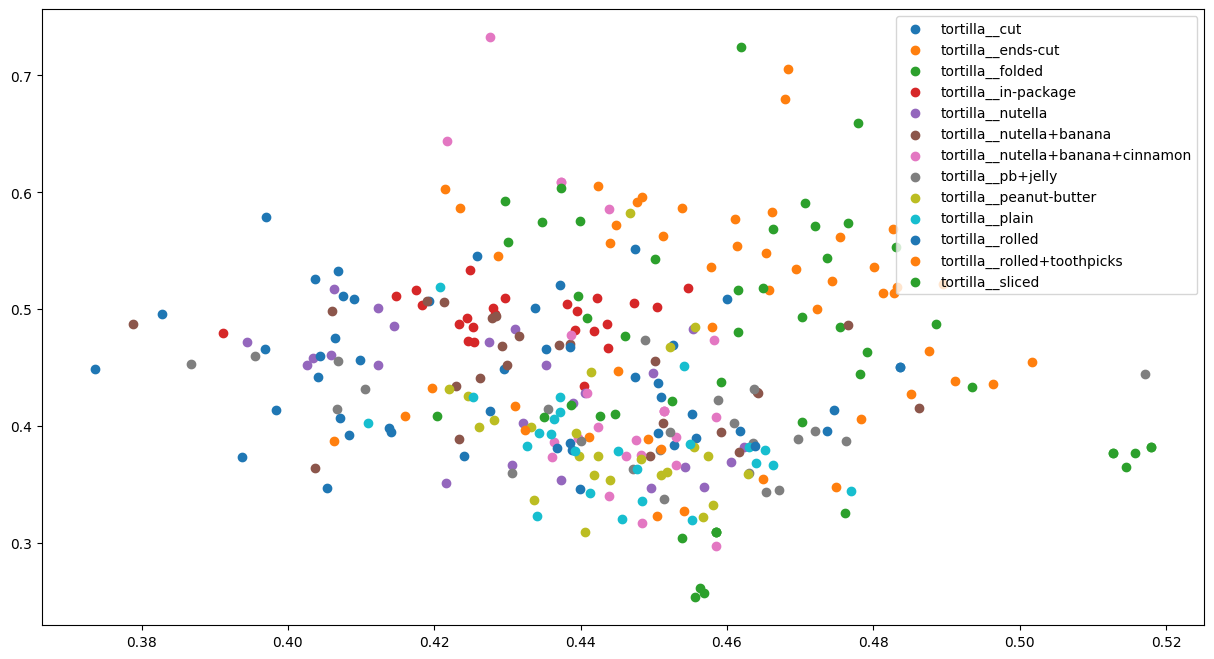

In [ ]:
plt.figure(figsize=(15, 8))
for l in np.unique(labels):
    p = pca_features.reshape(-1, patch_h, patch_w, 3).mean(1).mean(1)
    plt.scatter(p[labels==l, 2], p[labels==l, 1], label=l)
plt.legend()

In [ ]:
def plot_features(pca_features, fname):
    cols = 8
    pca_ims = pca_features.reshape(-1, patch_h, patch_w, 3)
    idxs = np.argsort(labels)
    plt.figure(figsize=(32, 4*len(pca_ims)//cols))
    for i in tqdm.tqdm(range(0, len(pca_ims), cols)):
        for j in range(cols):
            if i+j < len(pca_ims):
                plt.subplot(len(pca_ims)//cols+1, cols, i+j+1)
                plt.imshow(pca_ims[idxs[i+j]])
                plt.title(labels[idxs[i+j]])
    plt.tight_layout()
    if fname:
        os.makedirs(os.path.dirname(fname) or '.', exist_ok=True)
        plt.savefig(fname)
        plt.close()

In [ ]:
plot_features(pca_features, 'plots/pca.jpg')

100%|██████████| 39/39 [00:03<00:00, 12.28it/s]


In [ ]:
def project_fg(zt, z, thresh, inverse=False):
    # segment/seperate the backgound and foreground using the first component
    bg = zt[:, 0] < 0.35 # from first histogram
    if inverse:
        bg = ~bg
    fg = ~bg
    
    # 2nd PCA for only foreground patches
    pca.fit(total_features[fg]) 
    zt2 = pca.transform(z[fg])
    zt2 = (zt2 - zt2[:, 0].min()) / (zt2[:, 0].max() - zt2[:, 0].min())
    zt2 = np.clip(zt2, 0, 1)
    
    rgb = zt.copy()
    rgb[bg] = 0
    rgb[fg] = zt2
    return rgb

In [ ]:
# # segment/seperate the backgound and foreground using the first component
# pca_features_bg = pca_features[:, 0] < 0.35 # from first histogram
# pca_features_fg = ~pca_features_bg

# # 2nd PCA for only foreground patches
# pca.fit(total_features[pca_features_fg]) 
# pca_features2 = pca.transform(total_features[pca_features_fg])
# pca_features2 = (pca_features2 - pca_features2[:, 0].min()) / (pca_features2[:, 0].max() - pca_features2[:, 0].min())
# pca_features2 = np.clip(pca_features2, 0, 1)

# pca_features_rgb = pca_features.copy()
# # for black background
# pca_features_rgb[pca_features_bg] = 0
# # new scaled foreground features
# pca_features_rgb[pca_features_fg] = pca_features2

pca_features_rgb = project_fg(pca_features, total_features, 0.35)
plot_features(pca_features_rgb, 'plots/pca2.jpg')

100%|██████████| 39/39 [00:03<00:00, 11.04it/s]


## Train

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize and crop
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.RandomRotation(10),      # Random rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/datasets/annotation_final_imagenet/static_real/state'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']}

# Calculate class weights to balance the dataset
class_counts = [image_datasets['train'].targets.count(class_id) for class_id in range(len(image_datasets['train'].classes))]
class_weights = 100.0 / (torch.tensor(class_counts, dtype=torch.float))
class_weights

tensor([0.0368, 0.0117, 0.0120, 0.0127, 0.0122, 2.6316, 2.5641, 0.0137, 0.3745,
        0.0074, 0.0458, 0.0335, 0.0244, 0.0186, 0.1009, 0.0145, 0.0102, 0.0169,
        0.0338, 0.0118, 0.1047, 0.6667, 0.0805, 0.1733, 1.4493, 0.0271, 0.0206,
        0.0230, 1.0417, 0.0184, 0.0206, 0.0228, 0.0789, 0.3378, 0.1232])

In [50]:
for c, w in zip(image_datasets['train'].classes, class_weights):
    print(c, w)

bowl__empty tensor(0.0368)
bowl__oatmeal+raisins tensor(0.0117)
bowl__oatmeal+raisins+banana tensor(0.0120)
bowl__oatmeal+raisins+banana+cinnamon tensor(0.0127)
bowl__oatmeal+raisins+banana+cinnamon+honey tensor(0.0122)
bowl__oatmeal+raisins+cinnamon tensor(2.6316)
bowl__oatmeal+raisins+cinnamon+honey tensor(2.5641)
bowl__oatmeal+water tensor(0.0137)
bowl__oatmeal[cooked] tensor(0.3745)
bowl__oatmeal[dry] tensor(0.0074)
mug__dripper+filter tensor(0.0458)
mug__dripper+filter+coffee[drained] tensor(0.0335)
mug__dripper+filter+coffee[dry] tensor(0.0244)
mug__dripper+filter+coffee[wet] tensor(0.0186)
mug__dripper[empty] tensor(0.1009)
mug__empty tensor(0.0145)
mug__tea-bag tensor(0.0102)
mug__tea-bag+stirrer tensor(0.0169)
mug__tea-bag+water tensor(0.0338)
mug__water tensor(0.0118)
plate__empty tensor(0.1047)
plate__with-food tensor(0.6667)
tortilla__cut tensor(0.0805)
tortilla__ends-cut tensor(0.1733)
tortilla__folded tensor(1.4493)
tortilla__in-package tensor(0.0271)
tortilla__nutella te

In [ ]:
class_weights.sum()

tensor(10.1756)

In [51]:
y_true = np.array([y for x,y in image_datasets['train'].samples])
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], 
        # sampler=WeightedRandomSampler(
        #     np.array(class_weights)[y_true], 
        #     len(image_datasets['train']), 
        #     replacement=True),
        shuffle=True,
        batch_size=16,
        num_workers=4),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'],
        batch_size=16,
        num_workers=4)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names

['bowl__empty',
 'bowl__oatmeal+raisins',
 'bowl__oatmeal+raisins+banana',
 'bowl__oatmeal+raisins+banana+cinnamon',
 'bowl__oatmeal+raisins+banana+cinnamon+honey',
 'bowl__oatmeal+raisins+cinnamon',
 'bowl__oatmeal+raisins+cinnamon+honey',
 'bowl__oatmeal+water',
 'bowl__oatmeal[cooked]',
 'bowl__oatmeal[dry]',
 'mug__dripper+filter',
 'mug__dripper+filter+coffee[drained]',
 'mug__dripper+filter+coffee[dry]',
 'mug__dripper+filter+coffee[wet]',
 'mug__dripper[empty]',
 'mug__empty',
 'mug__tea-bag',
 'mug__tea-bag+stirrer',
 'mug__tea-bag+water',
 'mug__water',
 'plate__empty',
 'plate__with-food',
 'tortilla__cut',
 'tortilla__ends-cut',
 'tortilla__folded',
 'tortilla__in-package',
 'tortilla__nutella',
 'tortilla__nutella+banana',
 'tortilla__nutella+banana+cinnamon',
 'tortilla__pb+jelly',
 'tortilla__peanut-butter',
 'tortilla__plain',
 'tortilla__rolled',
 'tortilla__rolled+toothpicks',
 'tortilla__sliced']

In [ ]:
# next(iter(WeightedRandomSampler(
#             np.array(class_weights)[y_true], 
#             len(image_datasets['train']), 
#             replacement=True)))

In [ ]:
# uniq=set()
# for i, (d, yy) in enumerate(dataloaders['train']):
#     for yy in yy.tolist():
#         uniq.add(yy)
#         if len(uniq)>1: 
#             print(i, yy)
#             break

In [ ]:
# uniq

In [ ]:
class LinearDinoClassifier(nn.Module):
    def __init__(self, dinov2):
        super().__init__()
        self.transformer = dinov2
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(class_names))
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        x = F.softmax(x, dim=-1)
        return x

# Create a new classification head using self-attention
class DinoClassifier(nn.Module):
    def __init__(self, model, in_features=feat_dim, num_attention_heads=2, hidden_dim=128):
        super().__init__()
        self.model = model
        self.attention = nn.MultiheadAttention(embed_dim=in_features, num_heads=num_attention_heads)
        self.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, len(class_names)),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        # Apply self-attention
        x = self.model.forward_features(x)['x_norm_patchtokens']
        x, _ = self.attention(x, x, x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

In [ ]:
def eval_plots(X, y, train_dataset, val_dataset):
    classes=np.array(train_dataset.classes)
    val_classes=np.array(val_dataset.classes)
    emission_plot('plots', X, val_classes[y], classes)
    cm_plot('plots', val_classes[y], classes[np.argmax(X, axis=1)], classes)

def emission_plot(plot_dir, X, y, classes, prefix='', show_ypred=False):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 16))
    plt.imshow(X.T, cmap='cubehelix', aspect='auto')
    cs = {c: i for i, c in enumerate(classes)}
    classes = list(classes)
    for c in set(y) - set(cs):
        cs[c] = len(cs)
        classes.append(c)
    plt.plot(np.array([cs[yi] for yi in y]), c='r')
    if show_ypred:
        plt.scatter(np.arange(len(X)), np.argmax(X, axis=1), c='white', s=5, alpha=0.2)
    ic = range(len(classes))
    plt.yticks(ic, [classes[i] for i in ic])
    plt.colorbar()
    plt.savefig(f'{plot_dir}/{prefix}emissions.png')
    plt.close()


def cm_plot(plot_dir, y_test, y_pred, classes, prefix=''):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    # classes = np.unique(y_test) if classes is None else classes
    cm = confusion_matrix(y_test, y_pred, labels=classes, normalize='true')*100
    # Plot and save the confusion matrix
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='magma', cbar=False, square=True,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix')
    plt.savefig(f'{plot_dir}/{prefix}confusion_matrix.png')
    plt.close()

In [ ]:
from collections import Counter

In [49]:
model = DinoClassifier(dinov2).cuda()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_epoch(epoch):
    running_loss = 0.0
    counter = Counter()
    for i, (inputs, labels) in enumerate(dataloaders["train"]):
        counter.update(labels.tolist())
        # print(inputs.shape)
        # print(labels)
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i and not i % 600:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
            eval_epoch(model, epoch)
            print(counter)

def eval_epoch(model, epoch):
    correct = 0
    total = 0
    result_outputs = []
    result_targets = []
    with torch.no_grad():
        for images, labels in dataloaders["val"]:
            # calculate outputs by running images through the network
            outputs = model(images.to(device))
            result_outputs.append(outputs.detach().cpu().numpy())
            result_targets.append(labels.detach().cpu().numpy())
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.to("cpu") == labels).sum().item()
    X = np.concatenate(result_outputs)
    y = np.concatenate(result_targets)
    classes = dataloaders['train'].dataset.classes
    val_classes = dataloaders['val'].dataset.classes
    emission_plot('plots', X, np.array(val_classes)[y], classes, f'e{epoch}')

    accuracy = correct / total
    print(f'Accuracy of the network on the {len(dataloaders["val"])} batches: {accuracy:.0%}')
    return accuracy, X, y

for epoch in range(12):
    train_epoch(epoch)
eval_epoch(model, epoch)
print('Finished Training')

[1,   601] loss: 40.854
Accuracy of the network on the 489 batches: 5%
Counter({11: 313, 24: 308, 26: 297, 4: 295, 20: 292, 10: 291, 9: 287, 27: 287, 29: 284, 18: 283, 22: 281, 3: 281, 33: 281, 2: 278, 17: 277, 23: 277, 6: 274, 30: 273, 13: 271, 31: 271, 14: 270, 19: 269, 25: 266, 12: 266, 5: 265, 21: 264, 1: 261, 28: 261, 32: 260, 0: 259, 7: 257, 15: 257, 8: 254, 34: 254, 16: 252})
[1,  1201] loss: 38.629
Accuracy of the network on the 489 batches: 6%
Counter({11: 591, 24: 586, 4: 582, 20: 581, 10: 573, 33: 567, 21: 565, 5: 564, 2: 563, 26: 560, 9: 558, 31: 555, 18: 554, 14: 553, 29: 553, 22: 552, 12: 548, 23: 547, 3: 546, 16: 545, 17: 542, 13: 541, 27: 540, 19: 537, 1: 536, 6: 535, 0: 535, 15: 534, 34: 531, 25: 530, 7: 528, 28: 527, 30: 526, 32: 521, 8: 510})
[1,  1801] loss: 37.932
Accuracy of the network on the 489 batches: 5%
Counter({10: 873, 2: 865, 4: 864, 11: 863, 22: 852, 14: 847, 33: 847, 26: 844, 24: 844, 28: 844, 31: 838, 21: 838, 20: 835, 12: 832, 5: 829, 27: 827, 29: 819